# Fine-tuning ViLT For visual question answering (VQA)

In this notebook, we are going to illustrate how to fine-tune the Vision-and-Language Transformer (ViLT) for visual question answering. This is going to be very similar to how one would fine-tune BERT: one just places a head on top that is randomly initialized, and trains it end-to-end together with a pre-trained base.

* Paper: https://arxiv.org/abs/2102.03334
* ViLT docs: https://huggingface.co/docs/transformers/master/en/model_doc/vilt


## Set-up environment

First, we install the Transformers library.

In [6]:
!pip install -q transformers

## Load data

Next, we load the data. The data of VQAv2 can be obtained from the [official website](https://visualqa.org/download.html).

For demonstration purposes, we only download the validation dataset. We download:
* the images (stored in a single folder)
* the questions (stored in a JSON)
* the annotations (stored in a JSON) a.k.a. the answers to the questions.

I've downloaded the images myself, and stored them locally.

### Read questions

First, we read the questions.

In [54]:
import os

# Get the current working directory
current_directory = os.getcwd()

# List files in the current directory
files = os.listdir(current_directory)

# Find the file with the name "questions.json"
questions_json_files = [file for file in files if file.endswith('.json') and 'questions' in file]

# Print the paths of all files matching the pattern
for file in questions_json_files:
    print(os.path.join(current_directory, file))

import json
#from google.colab import files
#f = files.upload()

file = open("/content/questions.json")

import json

try:
    with open('questions.json', 'r') as file:
        # Return JSON object as dictionary
        data_questions = json.load(file)
        print(data_questions.keys())
except json.JSONDecodeError as e:
    print("Error decoding JSON:", e)


/content/questions.json
dict_keys(['info', 'license', 'data_subtype', 'tast_type', 'data_type', 'questions'])


Let's see how many questions there are:

In [4]:
questions = data_questions['questions']
print("Number of questions:", len(questions))

Number of questions: 225


That's quite a lot! Let's take a look at the first one:

In [5]:
questions[0]

{'question': 'is this nurse putting on latex gloves?',
 'question_id': 11,
 'image_id': 1}

As we can see, this question is related to an image with a certain ID. How can we find back which image this is? The function below allows to get the ID from a corresponding filename. We'll use it to map between image IDs and their corresponding filenames.

In [45]:
from typing import Optional
import re

# Assuming you have a regex pattern for matching the filename
filename_re = re.compile(r'^(\d+)_.*$')

def id_from_filename(filename: str) -> Optional[int]:
    # Strip leading zeros from the filename
    filename_without_zeros = filename.lstrip('0')

    # Remove the trailing ".jpg" if present
    filename_without_extension = filename_without_zeros.replace('.PNG', '')

    return int(filename_without_extension)

# Example usage
filename = '0123.PNG'
id = id_from_filename(filename)
print(id)

123


In [46]:
from os import listdir
from os.path import isfile, join
from tqdm.auto import tqdm

from google.colab import files
f = files.upload()

import zipfile
import io

# Get the uploaded zip archive file
uploaded_zip_filename = next(iter(f))

# Extract the contents of the zip archive
with zipfile.ZipFile(io.BytesIO(f[uploaded_zip_filename]), 'r') as zip_ref:
    zip_ref.extractall('/content/')

# Function to list all files in a directory recursively
def list_files_recursive(root_dir):
    file_names = []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            # Get the filename without the directory path
            file_name = os.path.basename(file)
            file_names.append(file_name)
    return file_names

# Get the list of all files in the '/content/' directory and its subdirectories
file_names = list_files_recursive('/content/Images')

# Print the list of file names
print(file_names)


['0158.PNG', '0259.PNG', '0097.PNG', '0276.PNG', '0208.PNG', '0121.PNG', '0023.PNG', '0007.PNG', '0260.PNG', '0163.PNG', '0053.PNG', '0120.PNG', '0093.PNG', '0029.PNG', '0019.PNG', '0055.PNG', '0232.PNG', '0115.PNG', '0291.PNG', '0003.PNG', '0132.PNG', '0180.PNG', '0162.PNG', '0177.PNG', '0212.PNG', '0017.PNG', '0171.PNG', '0136.PNG', '0073.PNG', '0258.PNG', '0083.PNG', '0219.PNG', '0142.PNG', '0022.PNG', '0244.PNG', '0010.PNG', '0033.PNG', '0084.PNG', '0226.PNG', '0138.PNG', '0161.PNG', '0064.PNG', '0230.PNG', '0047.PNG', '0134.PNG', '0100.PNG', '0149.PNG', '0271.PNG', '0081.PNG', '0050.PNG', '0119.PNG', '0108.PNG', '0049.PNG', '0150.PNG', '0057.PNG', '0173.PNG', '0164.PNG', '0228.PNG', '0074.PNG', '0178.PNG', '0068.PNG', '0015.PNG', '0240.PNG', '0041.PNG', '0192.PNG', '0262.PNG', '0268.PNG', '0227.PNG', '0202.PNG', '0113.PNG', '0072.PNG', '0102.PNG', '0198.PNG', '0241.PNG', '0238.PNG', '0107.PNG', '0014.PNG', '0122.PNG', '0059.PNG', '0288.PNG', '0213.PNG', '0005.PNG', '0001.PNG', '01

We can map a filename to its ID as follows:

In [43]:
id_from_filename('0001.PNG')

1

We create 2 dictionaries, one that maps filenames to their IDs and one the other way around:

In [52]:
root = "/content/Images/"
import zipfile
import io

filename_to_id = {root + file: id_from_filename(file) for file in file_names}
id_to_filename = {v:k for k,v in filename_to_id.items()}

print(filename_to_id)
print(id_to_filename)

{'/content/Images/0158.PNG': 158, '/content/Images/0259.PNG': 259, '/content/Images/0097.PNG': 97, '/content/Images/0276.PNG': 276, '/content/Images/0208.PNG': 208, '/content/Images/0121.PNG': 121, '/content/Images/0023.PNG': 23, '/content/Images/0007.PNG': 7, '/content/Images/0260.PNG': 260, '/content/Images/0163.PNG': 163, '/content/Images/0053.PNG': 53, '/content/Images/0120.PNG': 120, '/content/Images/0093.PNG': 93, '/content/Images/0029.PNG': 29, '/content/Images/0019.PNG': 19, '/content/Images/0055.PNG': 55, '/content/Images/0232.PNG': 232, '/content/Images/0115.PNG': 115, '/content/Images/0291.PNG': 291, '/content/Images/0003.PNG': 3, '/content/Images/0132.PNG': 132, '/content/Images/0180.PNG': 180, '/content/Images/0162.PNG': 162, '/content/Images/0177.PNG': 177, '/content/Images/0212.PNG': 212, '/content/Images/0017.PNG': 17, '/content/Images/0171.PNG': 171, '/content/Images/0136.PNG': 136, '/content/Images/0073.PNG': 73, '/content/Images/0258.PNG': 258, '/content/Images/0083.

We can now find back the image to which the question 'Where is he looking?' corresponded:

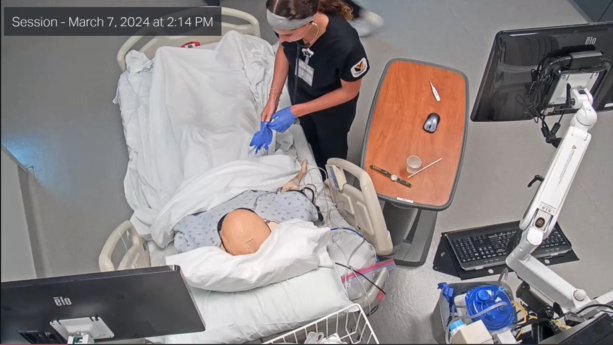

In [53]:
from PIL import Image

path = id_to_filename[questions[0]['image_id']]
image = Image.open(path)
image

### Read annotations

Next, let's read the annotations. As we'll see, every image is annotated with multiple possible answers.

In [59]:
import json

# Read annotations
f = open('/content/annotations.json')

# Return JSON object as dictionary
data_annotations = json.load(f)
print(data_annotations.keys())

dict_keys(['info', 'license', 'data_subtype', 'annotations'])


As we can see, there are 214354 annotations in total (for the validation dataset only!).

In [60]:
annotations = data_annotations['annotations']

In [61]:
print("Number of annotations:", len(annotations))

Number of annotations: 229


Let's take a look at the first one. As we can see, the example contains several answers (collected by different human annotators). The answer to a question can be a bit subjective: for instance for the question "where is he looking?", some people annotated this with "down", others with "table", another one with "skateboard", etc. So there's a bit of disambiguity among the annotators :)

In [62]:
annotations[0]

{'question_type': 'is this',
 'multiple_choice_answer': 'yes',
 'answers': [{'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 1}],
 'image_id': 1,
 'answer_type': 'yes/no',
 'question_id': 11}

## Add labels + scores

Due to this ambiguity, most authors treat the VQAv2 dataset as a multi-label classification problem (as multiple answers are possibly valid). Moreover, rather than just creating a one-hot encoded vector, one creates a soft encoding, based on the number of times a certain answer appeared in the annotations.

For instance, in the example above, the answer "down" seems to be selected way more often than "skateboard". Hence, we want the model to give more emphasis on "down" than on "skateboard". We can achieve this by giving a score of 1.0 to labels which are counted at least 3 times, and a score < 1.0 for labels that are counted less.

We'll add 2 keys to each annotations:
* labels, which is a list of integer indices of the labels that apply to a given image + question.
* scores, which are the corresponding scores (between 0 and 1), which indicate the importance of each label.

As we'll need the id2label mapping from the VQA dataset, we load it from the hub as follows:

In [63]:
from transformers import ViltConfig

config = ViltConfig.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/136k [00:00<?, ?B/s]

In [139]:
from tqdm.notebook import tqdm

for annotation in tqdm(annotations):
    answers = annotation['answers']
    answer_count = {}
    for answer in answers:
        answer_ = answer["answer"]
        answer_count[answer_] = answer_count.get(answer_, 0) + 1
    labels = []
    scores = []
    for answer in answer_count:
        if answer not in list(config.label2id.keys()):
            continue
        labels.append(config.label2id[answer])
        score = answer_count[answer]
        scores.append(score)
    annotation['labels'] = labels
    annotation['scores'] = scores

  0%|          | 0/229 [00:00<?, ?it/s]

Let's verify an example:

In [140]:
annotations[0]

{'question_type': 'is this',
 'multiple_choice_answer': 'yes',
 'answers': [{'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 1}],
 'image_id': 1,
 'answer_type': 'yes/no',
 'question_id': 11,
 'labels': [3],
 'scores': [1]}

Let's verify the labels and corresponding scores:

In [141]:
labels = annotations[0]['labels']
print([config.id2label[label] for label in labels])

['yes']


In [142]:
scores = annotations[0]['scores']
print(scores)

[1]


## Create PyTorch dataset

Next, we create a regular [PyTorch dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). We leverage `ViltProcessor` to prepare each image + text pair for the model, which will automatically:
* leverage `BertTokenizerFast` to tokenize the text and create `input_ids`, `attention_mask` and `token_type_ids`
* leverage `ViltImageProcessor` to resize + normalize the image and create `pixel_values` and `pixel_mask`.

Note that the docs of `ViltProcessor` can be found [here](https://huggingface.co/docs/transformers/master/en/model_doc/vilt#transformers.ViltProcessor).

We also add the labels. This is a PyTorch tensor of shape `(num_labels,)` that contains the soft encoded vector.

In [165]:
import torch
from PIL import Image

class VQADataset(torch.utils.data.Dataset):
    """VQA (v2) dataset."""

    def __init__(self, questions, annotations, processor):
        self.questions = questions
        self.annotations = annotations
        self.processor = processor

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        # get image + text
        annotation = self.annotations[idx]
        questions = self.questions[idx]
        image = Image.open(id_to_filename[annotation['image_id']]).convert('RGB')
        text = questions['question']

        encoding = self.processor(image, text, padding="max_length", truncation=True, return_tensors="pt")
        # remove batch dimension
        for k,v in encoding.items():
          encoding[k] = v.squeeze()
        # add labels
        labels = annotation['labels']
        #print("labels: ",labels)
        #print("array: ", [config.id2label[label] for label in labels])
        scores = annotation['scores']
        #print("scores: ", scores)
        # based on: https://github.com/dandelin/ViLT/blob/762fd3975c180db6fc88f577cf39549983fa373a/vilt/modules/objectives.py#L301
        targets = torch.zeros(len(config.id2label))
        #print("targets: ", targets)
        for label, score in zip(labels, scores):
              #print("score: ", score)
              #print("label: ", label)
              targets[label] = score
        # we want encoding["labels"] and targets to be the same as [config.id2label[label] for label in labels]
        encoding["labels"] = targets
        #print(encoding["labels"])

        return encoding

In [166]:
from transformers import ViltProcessor

processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-mlm")

dataset = VQADataset(questions=questions[:100],
                     annotations=annotations[:100],
                     processor=processor)

In [167]:
dataset[0].keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'pixel_values', 'pixel_mask', 'labels'])

In [168]:
processor.decode(dataset[0]['input_ids'])

'[CLS] is this nurse putting on latex gloves? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [169]:
labels = torch.nonzero(dataset[0]['labels']).squeeze().tolist()
lst = []
lst.append(labels)

In [170]:
[config.id2label[label] for label in lst]

['yes']

## Define model

Here we define a `ViltForQuestionAnswering` model, with the weights of the body initialized from dandelin/vilt-b32-mlm, and a randomly initialized classification head. We also move it to the GPU, if it's available.

In [171]:
from transformers import ViltForQuestionAnswering

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-mlm",
                                                 id2label=config.id2label,
                                                 label2id=config.label2id)
model.to(device)

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of ViltForQuestionAnswering were not initialized from the model checkpoint at dandelin/vilt-b32-mlm and are newly initialized: ['classifier.0.bias', 'classifier.0.weight', 'classifier.1.bias', 'classifier.1.weight', 'classifier.3.bias', 'classifier.3.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViltForQuestionAnswering(
  (vilt): ViltModel(
    (embeddings): ViltEmbeddings(
      (text_embeddings): TextEmbeddings(
        (word_embeddings): Embedding(30522, 768)
        (position_embeddings): Embedding(40, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (patch_embeddings): ViltPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
      )
      (token_type_embeddings): Embedding(2, 768)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViltEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViltLayer(
          (attention): ViltAttention(
            (attention): ViltSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=76

Next, we create a corresponding PyTorch DataLoader, which allows us to iterate over the dataset in batches.

Due to the fact that the processor resizes images to not necessarily the same size, we leverage the `pad_and_create_pixel_mask` method of the processor to pad the pixel values of a batch and create a corresponding pixel mask, which is a tensor of shape (batch_size, height, width) indicating which pixels are real (1) and which are padding (0).

In [172]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  input_ids = [item['input_ids'] for item in batch]
  pixel_values = [item['pixel_values'] for item in batch]
  attention_mask = [item['attention_mask'] for item in batch]
  token_type_ids = [item['token_type_ids'] for item in batch]
  labels = [item['labels'] for item in batch]

  # create padded pixel values and corresponding pixel mask
  encoding = processor.image_processor.pad(pixel_values, return_tensors="pt")

  # create new batch
  batch = {}
  batch['input_ids'] = torch.stack(input_ids)
  batch['attention_mask'] = torch.stack(attention_mask)
  batch['token_type_ids'] = torch.stack(token_type_ids)
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = torch.stack(labels)

  return batch

train_dataloader = DataLoader(dataset, collate_fn=collate_fn, batch_size=4, shuffle=True)

Let's verify a batch:

In [173]:
batch = next(iter(train_dataloader))

In [174]:
for k,v in batch.items():
  print(k, v.shape)

input_ids torch.Size([4, 40])
attention_mask torch.Size([4, 40])
token_type_ids torch.Size([4, 40])
pixel_values torch.Size([4, 3, 384, 608])
pixel_mask torch.Size([4, 384, 608])
labels torch.Size([4, 3129])


We can verify a given training example, by visualizing the image:

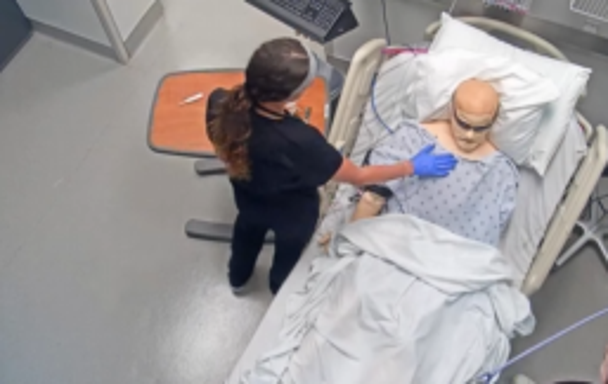

In [175]:
from PIL import Image
import numpy as np

image_mean = processor.image_processor.image_mean
image_std = processor.image_processor.image_std

batch_idx = 1

unnormalized_image = (batch["pixel_values"][batch_idx].numpy() * np.array(image_mean)[:, None, None]) + np.array(image_std)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

In [176]:
processor.decode(batch["input_ids"][batch_idx])

'[CLS] is this nurse listening to patients chest? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [177]:
labels = torch.nonzero(batch['labels'][batch_idx]).squeeze().tolist()

In [179]:
lst = []
lst.append(labels)

In [180]:
[config.id2label[label] for label in lst]

['no']

## Train a model

Finally, let's train a model! Note that I haven't done any hyperparameter tuning as this notebook was just created for demo purposes. I'd recommend going over the [ViLT paper](https://arxiv.org/abs/2102.03334) for better training settings.

I just wanted to illustrate that you can make the model overfit this dataset.

In [181]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

model.train()
for epoch in range(50):  # loop over the dataset multiple times
   print(f"Epoch: {epoch}")
   for batch in tqdm(train_dataloader):
        # get the inputs;
        batch = {k:v.to(device) for k,v in batch.items()}

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(**batch)
        loss = outputs.loss
        print("Loss:", loss.item())
        loss.backward()
        optimizer.step()

Epoch: 0


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 2271.9169921875
Loss: 2192.208740234375
Loss: 2126.76708984375
Loss: 2060.3837890625
Loss: 1997.52490234375
Loss: 1934.4102783203125
Loss: 1878.0048828125
Loss: 1821.3641357421875
Loss: 1763.53369140625
Loss: 1711.614990234375
Loss: 1660.61279296875
Loss: 1604.6466064453125
Loss: 1554.193359375
Loss: 1505.311767578125
Loss: 1455.1796875
Loss: 1408.7000732421875
Loss: 1362.0450439453125
Loss: 1317.37744140625
Loss: 1275.54443359375
Loss: 1232.828857421875
Loss: 1192.207763671875
Loss: 1153.0228271484375
Loss: 1115.502197265625
Loss: 1079.019775390625
Loss: 1044.2877197265625
Epoch: 1


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 1010.363037109375
Loss: 977.3992919921875
Loss: 945.4605712890625
Loss: 914.4635009765625
Loss: 884.6041870117188
Loss: 856.0442504882812
Loss: 828.7042236328125
Loss: 801.7233276367188
Loss: 775.9525146484375
Loss: 750.783447265625
Loss: 727.3425903320312
Loss: 704.023193359375
Loss: 681.8759155273438
Loss: 660.3302612304688
Loss: 640.0130004882812
Loss: 619.664794921875
Loss: 600.916015625
Loss: 583.0740356445312
Loss: 564.7208862304688
Loss: 548.1211547851562
Loss: 531.4857788085938
Loss: 515.4486694335938
Loss: 500.4168395996094
Loss: 486.1189270019531
Loss: 472.24017333984375
Epoch: 2


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 458.4438781738281
Loss: 445.8471984863281
Loss: 433.25811767578125
Loss: 421.6617736816406
Loss: 410.0422668457031
Loss: 399.2321472167969
Loss: 388.4972839355469
Loss: 378.31219482421875
Loss: 368.53375244140625
Loss: 359.28497314453125
Loss: 350.0525207519531
Loss: 341.3563232421875
Loss: 332.9131774902344
Loss: 324.8417053222656
Loss: 317.17144775390625
Loss: 309.5955810546875
Loss: 302.3661193847656
Loss: 295.3748779296875
Loss: 288.6219482421875
Loss: 282.08245849609375
Loss: 275.9450988769531
Loss: 269.98541259765625
Loss: 264.0372314453125
Loss: 258.3994140625
Loss: 253.10557556152344
Epoch: 3


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 247.5620574951172
Loss: 242.63375854492188
Loss: 237.45602416992188
Loss: 232.75477600097656
Loss: 228.2160186767578
Loss: 223.6515655517578
Loss: 219.24298095703125
Loss: 215.32003784179688
Loss: 211.04774475097656
Loss: 207.17715454101562
Loss: 203.34906005859375
Loss: 199.7733917236328
Loss: 195.9192352294922
Loss: 192.6728973388672
Loss: 188.86244201660156
Loss: 185.81996154785156
Loss: 182.7418975830078
Loss: 179.6217041015625
Loss: 176.33734130859375
Loss: 173.6077423095703
Loss: 170.7279510498047
Loss: 167.8201446533203
Loss: 165.18600463867188
Loss: 162.47402954101562
Loss: 159.82554626464844
Epoch: 4


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 157.31597900390625
Loss: 154.96047973632812
Loss: 152.44639587402344
Loss: 150.17098999023438
Loss: 147.94393920898438
Loss: 145.69464111328125
Loss: 143.477783203125
Loss: 141.43736267089844
Loss: 139.58004760742188
Loss: 137.4868927001953
Loss: 135.4265594482422
Loss: 133.5731201171875
Loss: 131.57107543945312
Loss: 129.7582550048828
Loss: 127.97075653076172
Loss: 126.2118148803711
Loss: 124.48814392089844
Loss: 122.88980102539062
Loss: 121.20272827148438
Loss: 119.58686065673828
Loss: 118.09545135498047
Loss: 116.66820526123047
Loss: 115.06681060791016
Loss: 113.713623046875
Loss: 112.26848602294922
Epoch: 5


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 110.64877319335938
Loss: 109.3644790649414
Loss: 107.85655975341797
Loss: 106.77066802978516
Loss: 105.31281280517578
Loss: 104.04256439208984
Loss: 102.69359588623047
Loss: 101.64839935302734
Loss: 100.56725311279297
Loss: 99.17342376708984
Loss: 98.25148010253906
Loss: 97.13446044921875
Loss: 95.89065551757812
Loss: 94.90092468261719
Loss: 93.82714080810547
Loss: 92.82950592041016
Loss: 91.58121490478516
Loss: 90.59439086914062
Loss: 89.60868072509766
Loss: 88.63429260253906
Loss: 87.73054504394531
Loss: 86.76530456542969
Loss: 85.83677673339844
Loss: 84.90437316894531
Loss: 84.02662658691406
Epoch: 6


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 83.15103149414062
Loss: 82.32953643798828
Loss: 81.48049926757812
Loss: 80.5829086303711
Loss: 79.78793334960938
Loss: 78.9832534790039
Loss: 78.21195983886719
Loss: 77.4547348022461
Loss: 76.65270233154297
Loss: 75.89152526855469
Loss: 75.1746597290039
Loss: 74.44686889648438
Loss: 73.6971435546875
Loss: 72.98419189453125
Loss: 72.27603912353516
Loss: 71.58309173583984
Loss: 70.92323303222656
Loss: 70.22331237792969
Loss: 69.60991668701172
Loss: 68.9632797241211
Loss: 68.26380157470703
Loss: 67.63279724121094
Loss: 67.19144439697266
Loss: 66.48576354980469
Loss: 65.8004379272461
Epoch: 7


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 65.20738983154297
Loss: 64.83546447753906
Loss: 64.26200103759766
Loss: 63.58356475830078
Loss: 62.83015060424805
Loss: 62.58287048339844
Loss: 62.03485107421875
Loss: 61.314762115478516
Loss: 60.878841400146484
Loss: 60.43724822998047
Loss: 59.913490295410156
Loss: 59.287742614746094
Loss: 58.889774322509766
Loss: 58.36186599731445
Loss: 57.82464599609375
Loss: 57.39368438720703
Loss: 56.925907135009766
Loss: 56.45830154418945
Loss: 56.02726364135742
Loss: 55.492923736572266
Loss: 55.098602294921875
Loss: 54.663841247558594
Loss: 54.180782318115234
Loss: 53.801090240478516
Loss: 53.25837326049805
Epoch: 8


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 52.88840866088867
Loss: 52.4605712890625
Loss: 51.93848419189453
Loss: 51.890811920166016
Loss: 51.37639617919922
Loss: 50.66648864746094
Loss: 50.608219146728516
Loss: 50.045310974121094
Loss: 49.853824615478516
Loss: 49.48338317871094
Loss: 48.908565521240234
Loss: 48.974586486816406
Loss: 48.39253616333008
Loss: 48.2408447265625
Loss: 47.67421340942383
Loss: 47.49972152709961
Loss: 46.97066116333008
Loss: 46.77617645263672
Loss: 46.529205322265625
Loss: 45.867515563964844
Loss: 45.63127517700195
Loss: 45.263526916503906
Loss: 44.95026779174805
Loss: 44.646976470947266
Loss: 44.39636993408203
Epoch: 9


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 44.085792541503906
Loss: 43.745975494384766
Loss: 43.443695068359375
Loss: 43.14801788330078
Loss: 42.82444381713867
Loss: 42.5758171081543
Loss: 42.26888656616211
Loss: 42.00754928588867
Loss: 41.72502899169922
Loss: 41.41066360473633
Loss: 41.14219284057617
Loss: 40.83286666870117
Loss: 40.63634490966797
Loss: 40.30115509033203
Loss: 39.994197845458984
Loss: 39.809661865234375
Loss: 39.487098693847656
Loss: 39.3916015625
Loss: 39.0568962097168
Loss: 38.80388641357422
Loss: 38.353939056396484
Loss: 38.31471252441406
Loss: 38.07791519165039
Loss: 37.84199142456055
Loss: 37.736568450927734
Epoch: 10


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 37.49907684326172
Loss: 37.25214385986328
Loss: 36.99934768676758
Loss: 36.65974044799805
Loss: 36.436622619628906
Loss: 36.26333999633789
Loss: 35.992069244384766
Loss: 35.76319885253906
Loss: 35.56587600708008
Loss: 35.35844802856445
Loss: 35.13420486450195
Loss: 34.91944122314453
Loss: 34.70936584472656
Loss: 34.503997802734375
Loss: 34.30226516723633
Loss: 34.12738037109375
Loss: 33.89605712890625
Loss: 33.64105224609375
Loss: 33.4228630065918
Loss: 33.36945343017578
Loss: 32.98091506958008
Loss: 32.93340301513672
Loss: 32.650306701660156
Loss: 32.572731018066406
Loss: 32.52693557739258
Epoch: 11


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 32.06653594970703
Loss: 31.88481330871582
Loss: 31.85296630859375
Loss: 31.672012329101562
Loss: 31.172056198120117
Loss: 30.980602264404297
Loss: 30.972200393676758
Loss: 30.99781608581543
Loss: 30.832542419433594
Loss: 31.11504554748535
Loss: 30.492765426635742
Loss: 30.528728485107422
Loss: 30.15235137939453
Loss: 29.979862213134766
Loss: 29.977272033691406
Loss: 29.648143768310547
Loss: 29.48714828491211
Loss: 29.32311248779297
Loss: 29.169105529785156
Loss: 29.07869529724121
Loss: 28.758726119995117
Loss: 28.707365036010742
Loss: 28.481002807617188
Loss: 28.448423385620117
Loss: 28.29254150390625
Epoch: 12


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 28.142837524414062
Loss: 27.991907119750977
Loss: 27.822004318237305
Loss: 27.671754837036133
Loss: 27.53257942199707
Loss: 27.397294998168945
Loss: 27.258691787719727
Loss: 27.110218048095703
Loss: 26.965328216552734
Loss: 26.813785552978516
Loss: 26.617856979370117
Loss: 26.646087646484375
Loss: 26.530710220336914
Loss: 26.316837310791016
Loss: 26.291889190673828
Loss: 25.95690155029297
Loss: 25.823694229125977
Loss: 25.80755615234375
Loss: 25.56793212890625
Loss: 25.55759048461914
Loss: 25.433185577392578
Loss: 25.309045791625977
Loss: 25.061573028564453
Loss: 25.20450782775879
Loss: 25.081928253173828
Epoch: 13


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 24.826669692993164
Loss: 24.596092224121094
Loss: 24.794565200805664
Loss: 24.287181854248047
Loss: 24.432701110839844
Loss: 24.311622619628906
Loss: 24.12213134765625
Loss: 23.96019172668457
Loss: 23.82025718688965
Loss: 23.743257522583008
Loss: 23.6253662109375
Loss: 23.571805953979492
Loss: 23.533241271972656
Loss: 23.357099533081055
Loss: 23.24602508544922
Loss: 23.218448638916016
Loss: 23.033531188964844
Loss: 22.854267120361328
Loss: 22.827016830444336
Loss: 22.728275299072266
Loss: 22.620332717895508
Loss: 22.45157814025879
Loss: 22.34111976623535
Loss: 22.32089614868164
Loss: 22.316619873046875
Epoch: 14


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 22.293954849243164
Loss: 22.028409957885742
Loss: 21.925765991210938
Loss: 21.831838607788086
Loss: 21.732561111450195
Loss: 21.671892166137695
Loss: 21.565073013305664
Loss: 21.450159072875977
Loss: 21.383319854736328
Loss: 21.276079177856445
Loss: 21.181928634643555
Loss: 21.14397430419922
Loss: 21.047395706176758
Loss: 20.91180992126465
Loss: 20.822708129882812
Loss: 20.733402252197266
Loss: 20.663551330566406
Loss: 20.562437057495117
Loss: 20.462892532348633
Loss: 20.389751434326172
Loss: 20.298316955566406
Loss: 20.170289993286133
Loss: 20.014705657958984
Loss: 20.0580997467041
Loss: 19.8852481842041
Epoch: 15


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 19.900362014770508
Loss: 19.69292449951172
Loss: 20.06538963317871
Loss: 19.520793914794922
Loss: 19.765609741210938
Loss: 19.67086410522461
Loss: 19.13216209411621
Loss: 19.349685668945312
Loss: 19.42081069946289
Loss: 19.05449676513672
Loss: 19.23389434814453
Loss: 18.799055099487305
Loss: 18.955381393432617
Loss: 18.879091262817383
Loss: 18.914569854736328
Loss: 18.729066848754883
Loss: 18.558780670166016
Loss: 18.49492835998535
Loss: 18.585893630981445
Loss: 18.350440979003906
Loss: 18.359773635864258
Loss: 18.290855407714844
Loss: 18.215951919555664
Loss: 18.075355529785156
Loss: 18.004779815673828
Epoch: 16


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 18.010562896728516
Loss: 17.85124397277832
Loss: 17.970699310302734
Loss: 17.803998947143555
Loss: 17.73455047607422
Loss: 17.769216537475586
Loss: 17.691932678222656
Loss: 17.535886764526367
Loss: 17.463197708129883
Loss: 17.4056453704834
Loss: 17.3345947265625
Loss: 17.307538986206055
Loss: 17.223281860351562
Loss: 17.13926887512207
Loss: 17.083520889282227
Loss: 17.01534652709961
Loss: 16.956148147583008
Loss: 16.91187286376953
Loss: 16.83481216430664
Loss: 16.749713897705078
Loss: 16.67638397216797
Loss: 16.596790313720703
Loss: 16.58966827392578
Loss: 16.633224487304688
Loss: 16.37153434753418
Epoch: 17


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 16.29721450805664
Loss: 16.088472366333008
Loss: 16.158222198486328
Loss: 16.2694091796875
Loss: 16.22745704650879
Loss: 16.17234230041504
Loss: 16.582300186157227
Loss: 16.066617965698242
Loss: 16.42959213256836
Loss: 15.7365083694458
Loss: 16.046497344970703
Loss: 15.953245162963867
Loss: 15.736897468566895
Loss: 15.580371856689453
Loss: 15.704301834106445
Loss: 15.624420166015625
Loss: 15.541714668273926
Loss: 15.455726623535156
Loss: 15.423815727233887
Loss: 15.384374618530273
Loss: 15.374933242797852
Loss: 15.256143569946289
Loss: 15.210960388183594
Loss: 15.144173622131348
Loss: 15.073227882385254
Epoch: 18


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 15.004776954650879
Loss: 14.988531112670898
Loss: 14.944901466369629
Loss: 14.984395980834961
Loss: 14.838313102722168
Loss: 14.796093940734863
Loss: 14.96395492553711
Loss: 14.693471908569336
Loss: 14.732824325561523
Loss: 14.520813941955566
Loss: 14.476784706115723
Loss: 14.557269096374512
Loss: 14.342068672180176
Loss: 14.343971252441406
Loss: 14.286060333251953
Loss: 14.304011344909668
Loss: 14.265742301940918
Loss: 14.217694282531738
Loss: 14.075249671936035
Loss: 14.131962776184082
Loss: 13.977795600891113
Loss: 14.04453182220459
Loss: 14.11963176727295
Loss: 13.82706069946289
Loss: 13.913694381713867
Epoch: 19


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 14.003072738647461
Loss: 13.82263469696045
Loss: 13.659078598022461
Loss: 13.61401653289795
Loss: 13.807804107666016
Loss: 13.645861625671387
Loss: 13.496418952941895
Loss: 13.559599876403809
Loss: 13.617115020751953
Loss: 13.37354850769043
Loss: 13.34106159210205
Loss: 13.294661521911621
Loss: 13.349814414978027
Loss: 13.301986694335938
Loss: 13.364058494567871
Loss: 13.319181442260742
Loss: 13.085819244384766
Loss: 13.22258472442627
Loss: 13.091825485229492
Loss: 12.98698616027832
Loss: 12.95485782623291
Loss: 12.979100227355957
Loss: 13.003580093383789
Loss: 12.835169792175293
Loss: 12.803234100341797
Epoch: 20


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 12.82611083984375
Loss: 12.85056209564209
Loss: 12.745722770690918
Loss: 12.643922805786133
Loss: 12.725433349609375
Loss: 12.757518768310547
Loss: 12.54861831665039
Loss: 12.484482765197754
Loss: 12.515844345092773
Loss: 12.51450252532959
Loss: 12.439092636108398
Loss: 12.327658653259277
Loss: 12.327603340148926
Loss: 12.33057689666748
Loss: 12.370674133300781
Loss: 12.195684432983398
Loss: 12.154876708984375
Loss: 12.18980598449707
Loss: 12.069050788879395
Loss: 12.23962688446045
Loss: 11.980209350585938
Loss: 12.070088386535645
Loss: 12.153557777404785
Loss: 11.864619255065918
Loss: 11.964144706726074
Epoch: 21


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 11.791692733764648
Loss: 11.897637367248535
Loss: 11.862146377563477
Loss: 11.825983047485352
Loss: 11.923055648803711
Loss: 11.760143280029297
Loss: 11.717409133911133
Loss: 11.881362915039062
Loss: 11.569951057434082
Loss: 11.55379581451416
Loss: 11.581031799316406
Loss: 11.553817749023438
Loss: 11.561217308044434
Loss: 11.492257118225098
Loss: 11.429222106933594
Loss: 11.420973777770996
Loss: 11.410238265991211
Loss: 11.356534957885742
Loss: 11.323822975158691
Loss: 11.292511940002441
Loss: 11.278294563293457
Loss: 11.21642017364502
Loss: 11.177485466003418
Loss: 11.176923751831055
Loss: 11.089544296264648
Epoch: 22


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 11.191390991210938
Loss: 11.085307121276855
Loss: 10.970736503601074
Loss: 10.848376274108887
Loss: 11.004725456237793
Loss: 11.11245059967041
Loss: 10.952120780944824
Loss: 10.654060363769531
Loss: 10.908348083496094
Loss: 11.19368839263916
Loss: 10.691734313964844
Loss: 10.8110990524292
Loss: 10.775546073913574
Loss: 10.61612319946289
Loss: 10.582496643066406
Loss: 10.700199127197266
Loss: 10.37877082824707
Loss: 10.643878936767578
Loss: 10.780713081359863
Loss: 10.597408294677734
Loss: 10.552443504333496
Loss: 10.539856910705566
Loss: 10.793521881103516
Loss: 10.472314834594727
Loss: 10.340317726135254
Epoch: 23


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 10.41338062286377
Loss: 10.541932106018066
Loss: 10.354005813598633
Loss: 10.283011436462402
Loss: 10.297324180603027
Loss: 10.266475677490234
Loss: 10.221844673156738
Loss: 10.199764251708984
Loss: 10.197826385498047
Loss: 10.075691223144531
Loss: 10.21146297454834
Loss: 10.050662994384766
Loss: 10.005643844604492
Loss: 9.957880973815918
Loss: 10.328516960144043
Loss: 10.312105178833008
Loss: 9.737317085266113
Loss: 9.978243827819824
Loss: 10.245179176330566
Loss: 9.934708595275879
Loss: 9.904370307922363
Loss: 9.681644439697266
Loss: 9.859931945800781
Loss: 9.73519515991211
Loss: 9.998252868652344
Epoch: 24


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 9.685894966125488
Loss: 9.910629272460938
Loss: 9.731151580810547
Loss: 9.594258308410645
Loss: 9.67672061920166
Loss: 9.649683952331543
Loss: 9.59039306640625
Loss: 9.597264289855957
Loss: 9.594779968261719
Loss: 9.613884925842285
Loss: 9.493730545043945
Loss: 9.548772811889648
Loss: 9.537951469421387
Loss: 9.441082000732422
Loss: 9.449028015136719
Loss: 9.450117111206055
Loss: 9.382773399353027
Loss: 9.388391494750977
Loss: 9.362061500549316
Loss: 9.329075813293457
Loss: 9.326925277709961
Loss: 9.284785270690918
Loss: 9.2554931640625
Loss: 9.22528076171875
Loss: 9.219888687133789
Epoch: 25


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 9.197509765625
Loss: 9.171530723571777
Loss: 9.022359848022461
Loss: 9.059479713439941
Loss: 9.258206367492676
Loss: 9.123977661132812
Loss: 8.825797080993652
Loss: 8.920852661132812
Loss: 8.891948699951172
Loss: 8.872360229492188
Loss: 8.835400581359863
Loss: 8.797759056091309
Loss: 9.27917766571045
Loss: 9.278074264526367
Loss: 8.997613906860352
Loss: 9.240030288696289
Loss: 8.931182861328125
Loss: 9.381669998168945
Loss: 8.677906036376953
Loss: 8.857402801513672
Loss: 8.660640716552734
Loss: 8.935771942138672
Loss: 8.768056869506836
Loss: 8.739513397216797
Loss: 8.789377212524414
Epoch: 26


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 8.698354721069336
Loss: 8.649456977844238
Loss: 8.63853645324707
Loss: 8.647699356079102
Loss: 8.641317367553711
Loss: 8.591181755065918
Loss: 8.58834171295166
Loss: 8.555427551269531
Loss: 8.531965255737305
Loss: 8.522890090942383
Loss: 8.502777099609375
Loss: 8.550273895263672
Loss: 8.49512004852295
Loss: 8.42172908782959
Loss: 8.423578262329102
Loss: 8.405068397521973
Loss: 8.389182090759277
Loss: 8.39173412322998
Loss: 8.360161781311035
Loss: 8.309776306152344
Loss: 8.322242736816406
Loss: 8.344411849975586
Loss: 8.281389236450195
Loss: 8.221063613891602
Loss: 8.245144844055176
Epoch: 27


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 8.188389778137207
Loss: 8.15577507019043
Loss: 8.272465705871582
Loss: 8.174371719360352
Loss: 8.230363845825195
Loss: 8.148782730102539
Loss: 8.061751365661621
Loss: 8.112003326416016
Loss: 8.089424133300781
Loss: 8.01041316986084
Loss: 8.071956634521484
Loss: 8.040767669677734
Loss: 7.948207855224609
Loss: 7.824913501739502
Loss: 8.003918647766113
Loss: 8.09398078918457
Loss: 7.9734272956848145
Loss: 7.946638584136963
Loss: 7.8234148025512695
Loss: 7.9316725730896
Loss: 8.040671348571777
Loss: 8.02522087097168
Loss: 7.871965408325195
Loss: 7.860171318054199
Loss: 7.753712177276611
Epoch: 28


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 7.6476287841796875
Loss: 7.876842021942139
Loss: 7.778652667999268
Loss: 7.7850565910339355
Loss: 7.741905212402344
Loss: 7.737166881561279
Loss: 7.71536922454834
Loss: 7.688326835632324
Loss: 7.56555700302124
Loss: 7.616876602172852
Loss: 7.744326114654541
Loss: 7.812541484832764
Loss: 7.6940460205078125
Loss: 7.605970859527588
Loss: 7.562310695648193
Loss: 7.54402494430542
Loss: 7.54412317276001
Loss: 7.537106513977051
Loss: 7.487215042114258
Loss: 7.466767311096191
Loss: 7.434541702270508
Loss: 7.594936370849609
Loss: 7.594904899597168
Loss: 7.580048084259033
Loss: 7.3487868309021
Epoch: 29


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 7.41851282119751
Loss: 7.337517738342285
Loss: 7.476271629333496
Loss: 7.468568325042725
Loss: 7.37152624130249
Loss: 7.353703498840332
Loss: 7.381783962249756
Loss: 7.325191020965576
Loss: 7.314756393432617
Loss: 7.314098834991455
Loss: 7.297065734863281
Loss: 7.262014865875244
Loss: 7.271422386169434
Loss: 7.253424644470215
Loss: 7.241540908813477
Loss: 7.259559631347656
Loss: 7.210701942443848
Loss: 7.212584972381592
Loss: 7.163232326507568
Loss: 7.152324199676514
Loss: 7.150636672973633
Loss: 7.149284839630127
Loss: 7.128972053527832
Loss: 7.094052791595459
Loss: 7.016643047332764
Epoch: 30


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 7.002208232879639
Loss: 6.982305526733398
Loss: 6.937716007232666
Loss: 7.062885761260986
Loss: 7.295827388763428
Loss: 6.653784275054932
Loss: 6.843627452850342
Loss: 7.0820488929748535
Loss: 7.036159038543701
Loss: 7.065707206726074
Loss: 7.347809791564941
Loss: 7.303616046905518
Loss: 6.9941205978393555
Loss: 7.222761631011963
Loss: 7.145381927490234
Loss: 6.7530999183654785
Loss: 7.041238307952881
Loss: 6.89631986618042
Loss: 6.858453750610352
Loss: 6.841468334197998
Loss: 6.774759769439697
Loss: 6.8184919357299805
Loss: 6.776717185974121
Loss: 6.7885422706604
Loss: 6.777982711791992
Epoch: 31


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 6.751905918121338
Loss: 6.755958557128906
Loss: 6.743381500244141
Loss: 6.726871490478516
Loss: 6.675803184509277
Loss: 6.681320667266846
Loss: 6.803130149841309
Loss: 6.66819953918457
Loss: 6.674341678619385
Loss: 6.600142955780029
Loss: 6.668956756591797
Loss: 6.513166904449463
Loss: 6.6043171882629395
Loss: 6.6826090812683105
Loss: 6.514618873596191
Loss: 6.614724159240723
Loss: 6.5581374168396
Loss: 6.443456172943115
Loss: 6.550809860229492
Loss: 6.685108661651611
Loss: 6.551968097686768
Loss: 6.414891719818115
Loss: 6.413498401641846
Loss: 6.714653491973877
Loss: 6.41663122177124
Epoch: 32


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 6.277866363525391
Loss: 6.554939270019531
Loss: 6.359640598297119
Loss: 6.523008346557617
Loss: 6.429039478302002
Loss: 6.410860061645508
Loss: 6.322163105010986
Loss: 6.209113121032715
Loss: 6.37872838973999
Loss: 6.633261680603027
Loss: 6.360429763793945
Loss: 6.467555522918701
Loss: 6.155032634735107
Loss: 6.332643032073975
Loss: 6.317584991455078
Loss: 6.152511119842529
Loss: 6.389150619506836
Loss: 6.30612325668335
Loss: 6.341881275177002
Loss: 6.186182975769043
Loss: 6.272527694702148
Loss: 6.155012130737305
Loss: 6.295828342437744
Loss: 6.048916816711426
Loss: 6.367333889007568
Epoch: 33


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 6.109015941619873
Loss: 6.160908222198486
Loss: 6.017519474029541
Loss: 6.2542948722839355
Loss: 6.246340751647949
Loss: 6.206401824951172
Loss: 6.184386253356934
Loss: 6.112726211547852
Loss: 6.1304402351379395
Loss: 6.09365177154541
Loss: 6.068575382232666
Loss: 6.05012321472168
Loss: 6.001577854156494
Loss: 6.152980804443359
Loss: 5.963615417480469
Loss: 6.0385284423828125
Loss: 6.193591117858887
Loss: 5.931013107299805
Loss: 6.019082546234131
Loss: 6.281004905700684
Loss: 5.8967814445495605
Loss: 5.971024513244629
Loss: 6.096822261810303
Loss: 5.961654186248779
Loss: 5.899111747741699
Epoch: 34


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 6.02167272567749
Loss: 5.9549784660339355
Loss: 5.915682315826416
Loss: 5.9018449783325195
Loss: 5.904479026794434
Loss: 5.894263744354248
Loss: 5.889031410217285
Loss: 5.866126537322998
Loss: 5.870234966278076
Loss: 5.910615921020508
Loss: 5.877821445465088
Loss: 5.8432135581970215
Loss: 5.894598007202148
Loss: 5.83401346206665
Loss: 5.88630485534668
Loss: 5.833653926849365
Loss: 5.7568817138671875
Loss: 5.799459934234619
Loss: 5.7623291015625
Loss: 5.940150260925293
Loss: 5.830800533294678
Loss: 5.753525733947754
Loss: 5.494547367095947
Loss: 5.726844787597656
Loss: 5.746263027191162
Epoch: 35


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 5.696124076843262
Loss: 5.408087730407715
Loss: 5.887451171875
Loss: 5.378138542175293
Loss: 5.910356044769287
Loss: 5.310422420501709
Loss: 5.290484428405762
Loss: 5.696951866149902
Loss: 5.731453895568848
Loss: 6.119017601013184
Loss: 6.155083656311035
Loss: 6.039310932159424
Loss: 5.6038737297058105
Loss: 5.6236395835876465
Loss: 5.690601348876953
Loss: 5.637484073638916
Loss: 5.560224533081055
Loss: 5.585971355438232
Loss: 5.596124172210693
Loss: 5.564913272857666
Loss: 5.519015789031982
Loss: 5.531795978546143
Loss: 5.526645660400391
Loss: 5.543900012969971
Loss: 5.484614372253418
Epoch: 36


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 5.55277681350708
Loss: 5.4416823387146
Loss: 5.464389324188232
Loss: 5.472918510437012
Loss: 5.433909893035889
Loss: 5.3705244064331055
Loss: 5.416777610778809
Loss: 5.431365966796875
Loss: 5.331386089324951
Loss: 5.524795055389404
Loss: 5.207116603851318
Loss: 5.323575496673584
Loss: 5.643649578094482
Loss: 5.532508373260498
Loss: 5.2801313400268555
Loss: 5.3665852546691895
Loss: 5.206869602203369
Loss: 5.202174663543701
Loss: 5.432590961456299
Loss: 5.364294528961182
Loss: 5.075428009033203
Loss: 5.254927158355713
Loss: 5.323591232299805
Loss: 5.349647521972656
Loss: 5.257791042327881
Epoch: 37


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 5.198215007781982
Loss: 5.1555495262146
Loss: 5.1937665939331055
Loss: 5.2007365226745605
Loss: 5.079303741455078
Loss: 5.215389728546143
Loss: 5.158191680908203
Loss: 5.036046028137207
Loss: 5.1557745933532715
Loss: 5.208438873291016
Loss: 5.182741165161133
Loss: 5.287154674530029
Loss: 5.108039855957031
Loss: 5.152980327606201
Loss: 5.2222771644592285
Loss: 4.919882774353027
Loss: 4.878593444824219
Loss: 5.009825229644775
Loss: 5.269850730895996
Loss: 5.270713806152344
Loss: 5.195363521575928
Loss: 5.275107383728027
Loss: 5.05159854888916
Loss: 5.145102500915527
Loss: 5.117753505706787
Epoch: 38


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 4.970216274261475
Loss: 5.062992095947266
Loss: 5.040593147277832
Loss: 5.028240203857422
Loss: 4.959983825683594
Loss: 5.067506313323975
Loss: 5.112043380737305
Loss: 4.995944499969482
Loss: 4.939023971557617
Loss: 4.92444372177124
Loss: 4.9744086265563965
Loss: 4.889557361602783
Loss: 5.062115669250488
Loss: 4.925140857696533
Loss: 4.886199951171875
Loss: 4.8745808601379395
Loss: 4.935760974884033
Loss: 4.885573863983154
Loss: 4.81747579574585
Loss: 4.7680277824401855
Loss: 4.954620361328125
Loss: 5.0837788581848145
Loss: 4.790449619293213
Loss: 5.028542518615723
Loss: 5.017237186431885
Epoch: 39


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 4.63712215423584
Loss: 4.964335918426514
Loss: 4.82969331741333
Loss: 4.942663669586182
Loss: 4.803805351257324
Loss: 4.849666595458984
Loss: 4.692770004272461
Loss: 4.666527271270752
Loss: 4.588542461395264
Loss: 4.69637393951416
Loss: 4.689777851104736
Loss: 4.8939595222473145
Loss: 4.6805419921875
Loss: 4.443214416503906
Loss: 4.6568827629089355
Loss: 4.737241268157959
Loss: 4.830987930297852
Loss: 4.705827713012695
Loss: 4.634660720825195
Loss: 4.6577324867248535
Loss: 4.656030178070068
Loss: 4.711121559143066
Loss: 4.576246738433838
Loss: 4.49791145324707
Loss: 4.605900287628174
Epoch: 40


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 4.928865432739258
Loss: 4.553800582885742
Loss: 4.368988037109375
Loss: 4.43083381652832
Loss: 4.449824333190918
Loss: 4.4620041847229
Loss: 4.482813835144043
Loss: 4.373345375061035
Loss: 4.415487289428711
Loss: 4.3335747718811035
Loss: 4.298605442047119
Loss: 4.436925888061523
Loss: 4.32658052444458
Loss: 4.268675327301025
Loss: 4.610240459442139
Loss: 4.410776138305664
Loss: 4.3960957527160645
Loss: 4.228537082672119
Loss: 4.499394416809082
Loss: 4.215609073638916
Loss: 4.61148738861084
Loss: 4.58115291595459
Loss: 4.293974876403809
Loss: 4.312268257141113
Loss: 4.521304130554199
Epoch: 41


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 4.213832855224609
Loss: 4.262342929840088
Loss: 4.600544452667236
Loss: 4.151129245758057
Loss: 4.1019062995910645
Loss: 4.148810863494873
Loss: 4.12702751159668
Loss: 4.127676963806152
Loss: 4.078164577484131
Loss: 4.091087818145752
Loss: 4.119505882263184
Loss: 4.1898603439331055
Loss: 4.293984413146973
Loss: 4.084482192993164
Loss: 4.055356025695801
Loss: 4.0445637702941895
Loss: 4.082700729370117
Loss: 4.000808238983154
Loss: 4.073329925537109
Loss: 4.054221153259277
Loss: 4.158448219299316
Loss: 4.080960273742676
Loss: 3.9843080043792725
Loss: 4.411665916442871
Loss: 4.464323043823242
Epoch: 42


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 3.976306915283203
Loss: 3.9107985496520996
Loss: 4.104128360748291
Loss: 3.9647974967956543
Loss: 4.048945426940918
Loss: 3.90895676612854
Loss: 3.8768651485443115
Loss: 3.9077200889587402
Loss: 4.181463718414307
Loss: 3.8928956985473633
Loss: 4.163204669952393
Loss: 3.809680223464966
Loss: 3.8303346633911133
Loss: 3.82309627532959
Loss: 4.030474662780762
Loss: 4.100593566894531
Loss: 3.8475165367126465
Loss: 3.775834560394287
Loss: 3.7639198303222656
Loss: 3.804117441177368
Loss: 4.188299179077148
Loss: 3.731995105743408
Loss: 3.719128131866455
Loss: 3.726667642593384
Loss: 3.747251510620117
Epoch: 43


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 3.66725754737854
Loss: 3.6846134662628174
Loss: 3.6779439449310303
Loss: 3.7116379737854004
Loss: 3.648303985595703
Loss: 3.7430388927459717
Loss: 3.5835325717926025
Loss: 3.628859281539917
Loss: 3.735853433609009
Loss: 3.830056667327881
Loss: 3.7093396186828613
Loss: 3.6895346641540527
Loss: 3.6403417587280273
Loss: 3.736543655395508
Loss: 3.620666980743408
Loss: 3.847290277481079
Loss: 3.5980215072631836
Loss: 3.5423929691314697
Loss: 3.627648115158081
Loss: 3.877950668334961
Loss: 3.4879555702209473
Loss: 3.5400867462158203
Loss: 4.221192836761475
Loss: 3.998096227645874
Loss: 3.9569787979125977
Epoch: 44


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 3.586561679840088
Loss: 4.683231353759766
Loss: 3.5905649662017822
Loss: 3.555800437927246
Loss: 3.510260581970215
Loss: 3.5442349910736084
Loss: 3.623616933822632
Loss: 3.478578805923462
Loss: 3.5285210609436035
Loss: 3.855607509613037
Loss: 3.4500696659088135
Loss: 3.586975574493408
Loss: 3.4599802494049072
Loss: 3.5268051624298096
Loss: 3.7547099590301514
Loss: 3.479942560195923
Loss: 3.455780267715454
Loss: 4.058833599090576
Loss: 3.385551691055298
Loss: 3.496326446533203
Loss: 3.3764851093292236
Loss: 4.046566009521484
Loss: 3.390376329421997
Loss: 3.425964117050171
Loss: 3.91110897064209
Epoch: 45


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 3.3686888217926025
Loss: 3.9017152786254883
Loss: 3.389660120010376
Loss: 3.3487210273742676
Loss: 3.3689746856689453
Loss: 3.32924747467041
Loss: 3.3417012691497803
Loss: 3.3444182872772217
Loss: 3.382544994354248
Loss: 3.4849398136138916
Loss: 3.3130221366882324
Loss: 3.251317024230957
Loss: 3.3178441524505615
Loss: 3.47147536277771
Loss: 3.345588445663452
Loss: 3.340043067932129
Loss: 3.2838168144226074
Loss: 3.2828872203826904
Loss: 3.2608814239501953
Loss: 3.2226974964141846
Loss: 3.2298030853271484
Loss: 3.2338449954986572
Loss: 3.223008871078491
Loss: 3.821770668029785
Loss: 3.9009335041046143
Epoch: 46


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 3.2418344020843506
Loss: 3.1589910984039307
Loss: 3.197657585144043
Loss: 3.2027015686035156
Loss: 3.213330030441284
Loss: 3.1846632957458496
Loss: 3.2822232246398926
Loss: 3.1925101280212402
Loss: 3.165544271469116
Loss: 3.221308469772339
Loss: 3.1638612747192383
Loss: 3.147336483001709
Loss: 3.272247552871704
Loss: 3.1660068035125732
Loss: 3.6097140312194824
Loss: 3.126742362976074
Loss: 3.099498748779297
Loss: 3.090683937072754
Loss: 3.0816962718963623
Loss: 3.076657295227051
Loss: 3.0838966369628906
Loss: 3.1292736530303955
Loss: 3.0593650341033936
Loss: 3.4714536666870117
Loss: 3.0511837005615234
Epoch: 47


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 3.051117420196533
Loss: 3.099029302597046
Loss: 3.0721232891082764
Loss: 3.266866683959961
Loss: 3.1446197032928467
Loss: 3.0527005195617676
Loss: 3.0134387016296387
Loss: 3.0120370388031006
Loss: 3.070040464401245
Loss: 3.6760706901550293
Loss: 3.0233144760131836
Loss: 3.2588775157928467
Loss: 3.016500473022461
Loss: 2.9793550968170166
Loss: 3.5924482345581055
Loss: 3.016669511795044
Loss: 2.97811222076416
Loss: 3.0211195945739746
Loss: 3.013106346130371
Loss: 3.017954111099243
Loss: 2.9960012435913086
Loss: 2.9973104000091553
Loss: 3.068345069885254
Loss: 2.9521570205688477
Loss: 2.9235293865203857
Epoch: 48


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 2.963289976119995
Loss: 2.94943904876709
Loss: 3.363452911376953
Loss: 2.9390041828155518
Loss: 2.9075729846954346
Loss: 2.90374493598938
Loss: 2.9644992351531982
Loss: 2.9929239749908447
Loss: 2.95011568069458
Loss: 2.901378870010376
Loss: 2.8964197635650635
Loss: 2.8760452270507812
Loss: 2.9105076789855957
Loss: 3.3005449771881104
Loss: 2.850550413131714
Loss: 2.87113356590271
Loss: 2.840893268585205
Loss: 2.808403491973877
Loss: 3.257673978805542
Loss: 2.8864099979400635
Loss: 2.820439338684082
Loss: 2.8456647396087646
Loss: 2.863008499145508
Loss: 2.83437180519104
Loss: 2.7882421016693115
Epoch: 49


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 2.8200912475585938
Loss: 2.8196208477020264
Loss: 2.8318569660186768
Loss: 2.8153574466705322
Loss: 2.7839834690093994
Loss: 3.2852494716644287
Loss: 2.791095733642578
Loss: 2.7968530654907227
Loss: 2.7382700443267822
Loss: 2.7570712566375732
Loss: 2.774348735809326
Loss: 2.799734354019165
Loss: 2.971784830093384
Loss: 2.7617928981781006
Loss: 2.7730772495269775
Loss: 2.730311393737793
Loss: 2.7463150024414062
Loss: 2.7421019077301025
Loss: 3.094073534011841
Loss: 2.709679365158081
Loss: 2.724287986755371
Loss: 2.937849521636963
Loss: 2.7142257690429688
Loss: 2.7132396697998047
Loss: 2.706786870956421


## Inference

Let's verify whether the model has actually learned something:

In [182]:
example = dataset[0]
print(example.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'pixel_values', 'pixel_mask', 'labels'])


In [183]:
processor.decode(example['input_ids'])

'[CLS] is this nurse putting on latex gloves? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [184]:
# add batch dimension + move to GPU
example = {k: v.unsqueeze(0).to(device) for k,v in example.items()}

# forward pass
outputs = model(**example)

Note that we need to apply a sigmoid activation on the logits since the model is trained using binary cross-entropy loss (as it frames VQA as a multi-label classification task).

In [185]:
logits = outputs.logits
predicted_classes = torch.sigmoid(logits)

probs, classes = torch.topk(predicted_classes, 5)

for prob, class_idx in zip(probs.squeeze().tolist(), classes.squeeze().tolist()):
  print(prob, model.config.id2label[class_idx])

0.878399133682251 yes
0.12647058069705963 no
0.002009117044508457 deli
0.001999480649828911 yellow and red
0.0019988548010587692 opponent
